# Getting Embeddings

In [45]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 111]
[nltk_data]     Connection refused>


False

In [1]:
from transformers import BertModel, BertTokenizer,BertForPreTraining, BertConfig
from tqdm.auto import tqdm
import torch
import nltk
from pathlib import Path
import re
from scipy.spatial.distance import  cosine
import pickle
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
DATA_DIR = Path('data')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
SEEDS = ['finance', 'medicine', 'sports', 'technology']
NUM_WORDS_PER_SET = 10

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")


def get_embeddings(model, tokens, embedding_size=768):
    with torch.no_grad():
        output = model(**tokens)
        embedding = output.last_hidden_state[0][1]
        return torch.reshape(embedding, (embedding_size, ))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
def get_embeddings_batch(model, tokens, embedding_size=768, batch_size=4):
    with torch.no_grad():
        output = model(**tokens)
        embedding = output.last_hidden_state[:, 1, :]
        return embedding


def cos_distance_batch(topic, words):
    return np.inner(
        topic, words) / (np.linalg.norm(topic) * np.linalg.norm(words, axis=1))


def job(vocab, topic, tokenizer, model, batch_size=4):
    res_col = np.zeros((len(vocab), ))
    vocab = list(vocab)
    loop = tqdm(range(0, len(vocab), batch_size))
    loop.set_description(f"topic: {topic}")
    topic_token = tokenizer(topic,
                            return_tensors='pt',
                            padding=True,
                            max_length=10,
                            truncation=True)
    topic_emb = get_embeddings(model, topic_token)
    for batch_index in loop:
        lo = batch_index
        hi = min(batch_index + batch_size, len(vocab))
        batch = vocab[batch_index:batch_index + batch_size]
        tokens = tokenizer(batch,
                           return_tensors='pt',
                           padding='max_length',
                           max_length=10,
                           truncation=True)
        # if len(token['input_ids']) > 3:
        #     print(f"WARNING: Word '{word}' is not in BERT's vocabulary")
        word_embs = get_embeddings_batch(model, tokens)
        res_col[lo:hi] = cos_distance_batch(topic_emb, word_embs)
        # res_col.append(cosine(topic_emb, word_emb))
    return res_col

In [ ]:
token = tokenizer("medicine", return_tensors='pt', truncation=True)
print(token.input_ids.shape)
out = model(**token)
out.last_hidden_state.shape

In [ ]:
tokenizer('[MASK]')

In [ ]:
cat_emb = get_embeddings(cat_outputs)
hello_emb = get_embeddings(hello_outputs)
hi_emb = get_embeddings(hi_outputs)

print(cosine(hi_emb, hello_emb))
print(cosine(hi_emb, cat_emb))

In [ ]:
cosine([1], [0.1])

# Building vocab for the corpus

In [ ]:
df = pd.read_csv(Path('data') / 'content_cleaned.txt')
df.head()

In [ ]:

stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
def vocab_preprocess(row, lemmatize=True):
    from nltk.stem import WordNetLemmatizer
    row = row.lower().strip()
    words = row.split(' ')
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    res = {}
    for word in words:
        count = res.get(word, 0)
        count += 1
        res[word] = count
    if (lemmatize):
        words = [lemmatizer.lemmatize(word) for word in words]

    return res

In [ ]:
MIN_COUNT=3
f = open('data/content_cleaned.txt')
lines = f.readlines()
f.close()
data = []
vocab = {}
for i, row in tqdm(enumerate(lines)):
    freq = vocab_preprocess(row, False)
    for _word, _count in freq.items():
        count = vocab.get(_word, 0) + _count
        vocab[_word] = count
uncommon_words = []
for word, count in tqdm(vocab.items()):
    if count < MIN_COUNT:
       uncommon_words.append(word)
print(len(uncommon_words))
print(len(vocab.keys()))
for word in uncommon_words:
    del vocab[word]
print(len(vocab.keys()))
with open(DATA_DIR / "vocab" / "global_vocab_no_lemmatize.pkl", "wb") as f:
    pickle.dump(vocab, f)

# Build global rankings

In [ ]:
vocab = None
with open(DATA_DIR / "vocab" / "global_vocab_no_lemmatize.pkl", "rb") as f:
    vocab = pickle.load(f)
print(len(vocab))

In [ ]:

topic_embeddings = []
cols = []
for seed in SEEDS:
    cols.append(job(vocab, seed, tokenizer, model, batch_size=128))


In [ ]:
arr = np.array(cols)
res_dict = {
    '_vocab': list(vocab),
}
for i, topic in enumerate(SEEDS):
    print(arr[i].shape)
    res_dict[topic] = arr[i]
res_df = pd.DataFrame(res_dict)
res_df = res_df.set_index(['_vocab'])
res_df.to_csv('./results/global_cos_similarity.csv')
res_df.sort_values('finance', ascending=False).head(10)

In [ ]:
df = pd.read_csv('./results/global_cos_similarity.csv', index_col='_vocab')
for seed in SEEDS:
    line = df.sort_values(seed, ascending=False).head(4).index[1::]
    print(" ".join(line))

In [ ]:
res_df.sort_values(by='technology', ascending=False).head(10)

# Initialize word sets from $e$

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
res_df = pd.read_csv('global_cos_similarity.csv')
res_df = res_df.set_index(['_vocab'])
word_set = {}
added_words = set()
for seed in SEEDS:
    word_set[seed] = []
    col = res_df[seed]
    sorted_col = col.sort_values()[::-1]
    i = 0
    for word, _ in sorted_col.iteritems():
        if i == NUM_WORDS_PER_SET + 1:
            break
        if word not in added_words:
            word_set[seed].append(word)
            added_words.add(word)
            i += 1

word_set_df = pd.DataFrame(word_set)
word_set_df.head()

In [ ]:
for topic, words in word_set.items():
    print(f"{' '.join(words[1:4])}")

# Local Knowlege using pretrained BERT

In [ ]:
# Prepare datasets
from transformers import BertTokenizer, DataCollatorForLanguageModeling
from datasets import load_dataset, concatenate_datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
)
dataset = load_dataset('ag_news')

In [ ]:
concatenate_datasets([dataset['train'], dataset['test']], axis=0)

In [ ]:
%%bash

python3 scripts/train.py \
    -o ./models \
    -t ./data/tokens/tokens-pretrained-30522.pkl \
    -n bert-pretrined-30522 

# Compute Local Cosine similarity

In [ ]:
model = BertModel.from_pretrained('models/bert-pretrained-pretrained-30522-2022-06-22-10-34/checkpoint-10000')
model.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
with open('data/vocab/global_vocab_no_lemmatize.pkl', 'rb') as f:
    vocab = pickle.load(f)
len(vocab)

In [ ]:
def get_embeddings_batch(model, tokens, embedding_size=768, batch_size=4):
    with torch.no_grad():
        output = model(**tokens)
        embedding = output.last_hidden_state[:, 1, :]
        return embedding


def cos_distance_batch(topic, words):
    return np.inner(topic, words) / (np.linalg.norm(topic) * np.linalg.norm(words, axis=1))


def job(vocab, topic, tokenizer, model, batch_size=4):
    res_col = np.zeros((len(vocab), ))
    vocab = list(vocab)
    loop = tqdm(range(0, len(vocab), batch_size))
    loop.set_description(f"topic: {topic}")
    topic_token = tokenizer(topic, return_tensors='pt', padding=True, max_length=10, truncation=True)
    topic_emb = get_embeddings(model, topic_token)
    for batch_index in loop:
        lo = batch_index
        hi = min(batch_index + batch_size, len(vocab))
        batch = vocab[batch_index:batch_index + batch_size]
        tokens = tokenizer(batch, return_tensors='pt', padding='max_length', max_length=10, truncation=True)
        # if len(token['input_ids']) > 3:
        #     print(f"WARNING: Word '{word}' is not in BERT's vocabulary")
        word_embs = get_embeddings_batch(model, tokens)
        res_col[lo:hi] = cos_distance_batch(topic_emb, word_embs)
        # res_col.append(cosine(topic_emb, word_emb))
    return res_col

In [ ]:
res = []
for topic in SEEDS:
    res_col = job(vocab, topic, tokenizer, model, batch_size=256)
    res.append(res_col)

In [ ]:

arr = np.array(res)
arr = arr.T
res_dict = {    
    '_vocab': list(vocab),
}
for i, topic in enumerate(SEEDS):
    res_dict[topic] = arr[:, i]
res_df = pd.DataFrame(res_dict)
res_df = res_df.set_index(['_vocab'])
res_df.to_csv('local_embeddings_bert-pretrained-pretrained.csv')

In [ ]:
res_df = pd.read_csv('./local_embeddings_bert-pretrained-pretrained.csv', index_col='_vocab')
res_df.sort_values('finance', ascending=False).head(10)

In [ ]:
# BERTopic

In [ ]:
from bertopic import BERTopic

seeds = np.array([SEEDS]).T.tolist()
topic_model = BERTopic(seed_topic_list=seeds)
docs = pd.read_csv(DATA_DIR / 'dataset.csv')['description']
topic_model.fit_transform(docs)

In [ ]:
similar_topics, similarity = topic_model.find_topics("finance", top_n=5)
for i, topic in enumerate(similar_topics):
    print(topic_model.get_topic(topic)[0][0], similarity[i])

# CatE
**kwown issue**: Seg Fault when seed words > 3

In [4]:
import pandas as pd

local_emb_vocab_df = pd.read_csv(
    'results/CatE/2022-07-07-12-43/emb_seeds_w.txt',
    sep=' ',
    skiprows=[0],
    index_col=0,
    header=None)
local_emb_vocab_df.dropna(axis=1, inplace=True)

local_emb_topic_df = pd.read_csv(
    'results/CatE/2022-07-07-12-43/emb_seeds_t.txt',
    sep=' ',
    skiprows=[0],
    index_col=0,
    header=None)
local_emb_topic_df.dropna(axis=1, inplace=True)


In [5]:
def compute_cate_cos_similarity(vocab, vocab_embs, topic_emb, topic, batch_size=32, show_progress=True):
    res_col = np.zeros((len(vocab), ))
    loop = range(0, len(vocab), batch_size)
    if show_progress:
        loop = tqdm(loop)
        loop.set_description(f"topic: {topic}")
    for batch_index in loop:
        lo = batch_index
        hi = min(batch_index + batch_size, len(vocab))

        batch = vocab[lo:hi]
        batch_embs = vocab_embs.loc[batch, :]
        res_col[lo:hi] = cos_distance_batch(topic_emb, batch_embs)
        # res_col.append(cosine(topic_emb, word_emb))
    return res_col

In [6]:
vocab_f = open('./data/vocab/global_vocab_no_lemmatize.pkl', 'rb')
vocab = pickle.load(vocab_f)
vocab_f.close()
not_in_vocab_words = []
for word in vocab.keys():
    if word not in local_emb_vocab_df.index:
        not_in_vocab_words.append(word)
print(len(not_in_vocab_words))
for word in not_in_vocab_words:
    del vocab[word]
for word in local_emb_vocab_df.index:
    if word not in vocab:
        local_emb_vocab_df =  local_emb_vocab_df.drop(word, axis=0)

1


In [7]:
res = {}
res['_vocab'] = vocab.keys()
for topic in local_emb_topic_df.index:
    topic_emb = local_emb_topic_df.loc[topic, :]
    res_col = compute_cate_cos_similarity(list(vocab.keys()), local_emb_vocab_df, topic_emb, topic, show_progress=False)
    res[topic] = res_col


In [8]:
res_df = pd.DataFrame(res)
res_df = res_df.set_index(['_vocab'])
res_df.to_csv('./results/CatE/2022-07-07-12-43/cate_local_embeddings.csv')

# Compute Ensemble ranking [Proposed]
Which does not work as expected -> CatE has different embeddings for the same word in topic and vocab

In [7]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
local_emb_vocab_df = pd.read_csv(
    'results/CatE/2022-07-07-12-43/emb_seeds_w.txt',
    sep=' ',
    skiprows=[0],
    index_col=0,
    header=None)
local_emb_vocab_df.dropna(axis=1, inplace=True)

local_emb_topic_df = pd.read_csv(
    'results/CatE/2022-07-07-12-43/emb_seeds_t.txt',
    sep=' ',
    skiprows=[0],
    index_col=0,
    header=None)
local_emb_topic_df.dropna(axis=1, inplace=True)

In [8]:
def compute_vocab_cos_similarity(emb):
    out_shape = (emb.shape[0], emb.shape[0])
    df = pd.DataFrame(np.zeros((out_shape)), index=emb.index, columns=emb.index)
    for word in tqdm(emb.index):
        topic_emb = emb.loc[word, :]
        res_row = cos_distance_batch(topic_emb, emb)
        df.loc[word, :] = res_row
    return df
res = compute_vocab_cos_similarity(local_emb_vocab_df)
res.to_csv('results/CatE/2022-07-07-12-43/cate_cos_similarities.csv')

  0%|          | 0/26022 [00:00<?, ?it/s]

NameError: name 'cos_distance_batch' is not defined

In [ ]:
res.loc['accounting', 'unumprovident']

In [ ]:
cosine(local_emb_vocab_df.loc['accounting', :], local_emb_topic_df.loc['accounting', :])

# Compute emsemble ranking [CatE]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
global_cos_df = pd.read_csv('./results/global_cos_similarity.csv', index_col=0)
local_cos_df = pd.read_csv('./results/cate_local_embeddings.csv', index_col=0)
# min_max_scalar


In [ ]:
def ensemble_ranking(score_g, score_l, rho):
    exponent = 1 / rho
    base = 0.5 * np.power(1/score_g, rho) + 0.5 * np.power(1/score_l, rho) 
    return 1/np.power(base, exponent)

def scale_data(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

def compute_vocab_ensemble_rankings(score_l_df, score_g_df, vocab, rho=1): 
    raw = np.zeros((len(vocab), score_l_df.shape[1])).astype(np.double)
    res = pd.DataFrame(raw, index=vocab, columns=score_g_df.columns)
    for topic_idx in range(score_l_df.shape[1]):
        score_l = score_l_df.loc[vocab, score_l_df.columns[topic_idx]]
        score_g = score_g_df.loc[vocab, score_g_df.columns[topic_idx]]
        res.iloc[:, topic_idx] = ensemble_ranking(score_l, score_g, rho)
    return res
s_global_cos_df = scale_data(global_cos_df)
local_cos_df.loc[:, :] = scale_data(local_cos_df)
global_cos_df.loc[:, :] = scale_data(global_cos_df)
res = compute_vocab_ensemble_rankings(local_cos_df, global_cos_df, local_cos_df.index)
res['finance'].sort_values(ascending=False)
res.to_csv('./results/ensemble/cate_ensemble_rankings.csv') 

# Compute emsemble ranking [BERT-pretrained]

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
global_cos_df = pd.read_csv('./results/global_cos_similarities.csv', index_col=0)
local_cos_df = pd.read_csv('./results/bert/bert-pretrained.csv', index_col=0)

In [ ]:
def ensemble_ranking(score_g, score_l, rho):
    exponent = 1 / rho
    base = 0.4 * np.power(1/score_g, rho) + 0.6 * np.power(1/score_l, rho) 
    return 1/np.power(base, exponent)

def compute_vocab_ensemble_rankings(score_l_df, score_g_df, vocab, rho=0.5): 
    raw = np.zeros((len(vocab), score_l_df.shape[1])).astype(np.double)
    res = pd.DataFrame(raw, index=vocab, columns=score_g_df.columns)
    for topic_idx in range(score_l_df.shape[1]):
        score_l = score_l_df.loc[vocab, score_l_df.columns[topic_idx]]
        score_g = score_g_df.loc[vocab, score_g_df.columns[topic_idx]]
        res.iloc[:, topic_idx] = ensemble_ranking(score_l, score_g, rho)
    return res
res = compute_vocab_ensemble_rankings(global_cos_df, local_cos_df, local_cos_df.index)
res['finance'].sort_values(ascending=False)


# Build occurance matrix

In [ ]:
import pickle
import pandas as pd
import numpy as np 
from tqdm.auto import tqdm
with open('./data/vocab/global_vocab_no_lemmatize.pkl', 'rb') as f:
    vocab = pickle.load(f)
data = np.zeros((len(vocab), len(vocab)))
cooccur = pd.DataFrame(columns=vocab.keys(), index=vocab.keys(), data=data)
with open('./data/content_cleaned.txt') as f:
    lines =  f.readlines()
    for line in tqdm(lines):
        words = [word for word in line.split(' ') if word in vocab.keys()]
        for word_x in words: 
            for word_y in words:
                if word_x != word_y:
                    cooccur.loc[word_x, word_y] += 1



In [19]:
import json
import nltk
def compute_distinctiveness(word_sets):
    words = list(word_sets.values())
    topics = list(word_sets.keys())
    words = [set(v) for v in words]
    total_items = 0
    unique_words = set()
    words_to_remove = set()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    semantically_unique_words = set()
    for s, _ in zip(words, topics):
        total_items += len(s)
        unique_words = unique_words.union(s)
    distinctiveness = len(unique_words) / total_items
    for word in unique_words:
        for topic in topics:
            if word.startswith(topic) or topic.startswith(word):
                words_to_remove.add(word)
    
    print(words_to_remove)
    unique_words = (unique_words - words_to_remove).union(set(topics))
    for word in unique_words:
        semantically_unique_words.add(lemmatizer.lemmatize(word))
    print(len(semantically_unique_words))
    sem_dist = (len(semantically_unique_words)) / total_items
    print("====DISTINCTIVENESS====")
    print(f"\t<SUM>: {distinctiveness}")
    print(f"\t<SEMANTICALLY DISTINCT>: {sem_dist}")
    return distinctiveness, sem_dist

with open('./results/pmis/run-2022-07-06-10-22/local-0.7-global-0.3-rho-0.5.json', 'r') as f:
    res = json.load(f)
word_set = res['ensemble_score_bert-local-scratch-25000']['word_set']
compute_distinctiveness(word_set)

{'sports', 'technology', 'sport', 'finance', 'sportsmen', 'medicine'}
34
====DISTINCTIVENESS====
	<SUM>: 0.925
	<SEMANTICALLY DISTINCT>: 0.85


(0.925, 0.85)

In [ ]:
cooccur['finance', 'banking']

In [ ]:
cooccur.loc['finance','finance']
cooccur.to_csv('./data/vocab/cooccurence_matrix_quick.csv')

In [ ]:
cooccur_new.loc['finance', 'finance']
cooccur_new.to_csv('./data/vocab/cooccurence_matrix.csv')

# Build PMI

In [ ]:
import numpy as np
import pandas as pd
cooccur_mat = pd.read_csv('./data/vocab/cooccurence_matrix-agnews.csv', index_col=0)


In [ ]:
scores_df = pd.read_csv(
    "results/ensemble/ensemble_score_bert-pretrained_2022-07-03-13-12.csv", index_col='_vocab')
SEEDS = ['finance', 'sports', 'medicine', 'technology']
res = {}
for topic in SEEDS:
    res[topic] = list(scores_df[topic].sort_values(ascending=False).head(5).index)
res

In [ ]:
def prob_word(word, mat):
    return np.sum(mat[word]) / np.sum(mat.to_numpy())
def prob_cooccur(a, b, mat):
    return mat.loc[a, b] / np.sum(mat.to_numpy())
def pmi(a, b, mat):
    prob_a=prob_word(a, mat)
    prob_b=prob_word(b, mat)
    prob_ab_cooccur = prob_cooccur(a,b, mat)
    return prob_ab_cooccur / (prob_a * prob_b)
pmis = {}

In [ ]:
pmis = {}
for topic in SEEDS:
    pmis[topic] = np.sum([pmi(word, topic, cooccur_mat) for word in res[topic]])
pmis

In [ ]:
cooccur_mat.loc['medicine', 'pathology']

In [4]:
import pandas as pd

local_emb_vocab_df = pd.read_csv('./results/CatE/emb_seeds_w.txt', sep=' ', skiprows=[0], index_col=0, header=None)
local_emb_vocab_df.dropna(axis=1, inplace=True)

local_emb_topic_df = pd.read_csv('./results/CatE/emb_seeds_t.txt', sep=' ', skiprows=[0], index_col=0, header=None)
local_emb_topic_df.dropna(axis=1, inplace=True)

In [43]:
def compute_vocab_cos_similarity(emb):
    out_shape = (emb.shape[0], emb.shape[0])
    df = pd.DataFrame(np.zeros((out_shape)), index=emb.index, columns=emb.index)
    for word in tqdm(emb.index):
        topic_emb = emb.loc[word, :]
        res_row = cos_distance_batch(topic_emb, emb)
        df.loc[word, :] = res_row
    return df
res = compute_vocab_cos_similarity(local_emb_vocab_df)

  0%|          | 0/25876 [00:00<?, ?it/s]

In [44]:
res.loc['accounting', 'unumprovident']

0.5662511389486806

In [50]:
cosine(local_emb_vocab_df.loc['accounting', :], local_emb_topic_df.loc['accounting', :])

0.33416083167506283

# Compute emsemble ranking [CatE]

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
global_cos_df = pd.read_csv('./results/global_cos_similarity.csv', index_col=0)
local_cos_df = pd.read_csv('./results/cate_local_embeddings.csv', index_col=0)
# min_max_scalar


In [14]:
def ensemble_ranking(score_g, score_l, rho):
    exponent = 1 / rho
    base = 0.5 * np.power(1/score_g, rho) + 0.5 * np.power(1/score_l, rho) 
    return 1/np.power(base, exponent)

def scale_data(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

def compute_vocab_ensemble_rankings(score_l_df, score_g_df, vocab, rho=1): 
    raw = np.zeros((len(vocab), score_l_df.shape[1])).astype(np.double)
    res = pd.DataFrame(raw, index=vocab, columns=score_g_df.columns)
    for topic_idx in range(score_l_df.shape[1]):
        score_l = score_l_df.loc[vocab, score_l_df.columns[topic_idx]]
        score_g = score_g_df.loc[vocab, score_g_df.columns[topic_idx]]
        res.iloc[:, topic_idx] = ensemble_ranking(score_l, score_g, rho)
    return res
s_global_cos_df = scale_data(global_cos_df)
local_cos_df.loc[:, :] = scale_data(local_cos_df)
global_cos_df.loc[:, :] = scale_data(global_cos_df)
res = compute_vocab_ensemble_rankings(local_cos_df, global_cos_df, local_cos_df.index)
res['finance'].sort_values(ascending=False)
res.to_csv('./results/ensemble/cate_ensemble_rankings.csv') 

# Compute emsemble ranking [BERT-pretrained]

In [9]:
import pandas as pd
import numpy as np

In [24]:
global_cos_df = pd.read_csv('./results/global_cos_similarities.csv', index_col=0)
local_cos_df = pd.read_csv('./results/bert/bert-pretrained.csv', index_col=0)

In [28]:
def ensemble_ranking(score_g, score_l, rho):
    exponent = 1 / rho
    base = 0.4 * np.power(1/score_g, rho) + 0.6 * np.power(1/score_l, rho) 
    return 1/np.power(base, exponent)

def compute_vocab_ensemble_rankings(score_l_df, score_g_df, vocab, rho=0.5): 
    raw = np.zeros((len(vocab), score_l_df.shape[1])).astype(np.double)
    res = pd.DataFrame(raw, index=vocab, columns=score_g_df.columns)
    for topic_idx in range(score_l_df.shape[1]):
        score_l = score_l_df.loc[vocab, score_l_df.columns[topic_idx]]
        score_g = score_g_df.loc[vocab, score_g_df.columns[topic_idx]]
        res.iloc[:, topic_idx] = ensemble_ranking(score_l, score_g, rho)
    return res
res = compute_vocab_ensemble_rankings(global_cos_df, local_cos_df, local_cos_df.index)
res['finance'].sort_values(ascending=False)


_vocab
finance       1.000000
banking       0.768596
securities    0.746399
financing     0.737215
finances      0.736829
                ...   
olof          0.089758
indah         0.088084
obasanjo      0.086977
morten        0.083190
winky         0.068860
Name: finance, Length: 25877, dtype: float64

# Build occurance matrix

In [3]:
import pickle
import pandas as pd
import numpy as np 
from tqdm.auto import tqdm
with open('./data/vocab/global_vocab_no_lemmatize.pkl', 'rb') as f:
    vocab = pickle.load(f)
data = np.zeros((len(vocab), len(vocab)))
cooccur = pd.DataFrame(columns=vocab.keys(), index=vocab.keys(), data=data)
with open('./data/content_cleaned.txt') as f:
    lines =  f.readlines()
    for line in tqdm(lines):
        words = [word for word in line.split(' ') if word in vocab.keys()]
        for word_x in words: 
            for word_y in words:
                if word_x != word_y:
                    cooccur.loc[word_x, word_y] += 1



  0%|          | 0/127600 [00:00<?, ?it/s]

In [15]:
cooccur['finance', 'banking']

KeyError: ('finance', 'banking')

In [32]:
cooccur.loc['finance','finance']
cooccur.to_csv('./data/vocab/cooccurence_matrix_quick.csv')

In [33]:
cooccur_new.loc['finance', 'finance']
cooccur_new.to_csv('./data/vocab/cooccurence_matrix.csv')

# Build PMI

In [7]:
cooccur_mat.loc['medicine', 'pathology']

0.0

In [1]:
from pathlib import Path
from scripts.evaluation import evaluation
import pandas as pd

PROJECT_ROOT = Path(
    "~/code/github.com/zhangchi0104/honours-sgtm").expanduser().absolute()
CONFIG = {
    # local_weight, global_weight, rho
    "specs": [
        # changes in weights
        (0.3, 0.7, 0.5),
        (0.4, 0.6, 0.5),
        (0.5, 0.5, 0.5),
        (0.6, 0.4, 0.5),
        (0.7, 0.3, 0.5),
        # changes in rho
        (0.5, 0.5, 0.1),
        (0.5, 0.5, 0.3),
        (0.5, 0.5, 0.7),
        (0.5, 0.5, 0.9),
    ],
    "inputs": [
        *(PROJECT_ROOT / 'results' / 'bert').glob("*"),
        (PROJECT_ROOT / 'results' / 'CatE' / '2022-07-03-09-36' /
         'cate-cos-similarities.csv')
    ],
    "baselines": [
        PROJECT_ROOT / 'results' / 'global_cos_similarities.csv',
        PROJECT_ROOT / 'results' / 'cate_cos_similarities.csv'
    ],
    "global_score":
    PROJECT_ROOT / 'results' / 'global_cos_similarities.csv',
    "n_words":
    10
}
cooccur_mat = pd.read_csv(PROJECT_ROOT / 'data' / 'vocab' /
                          'cooccurence_matrix-agnews.csv',
                          index_col=0)
evaluation([str(p) for p in CONFIG['baselines']],
           cooccur_mat,
           out=PROJECT_ROOT / 'results' / 'evaluations' / 'baselines.json')


SUMMARY
/home/alexzhang/code/github.com/zhangchi0104/honours-sgtm/results/global_cos_similarities.csv
====WORD SET====
	finance:['finance', 'accounting', 'logistics', 'marketing', 'banking']
	medicine:['medicine', 'dentistry', 'pharmacy', 'pathology', 'diseases']
	sports:['sports', 'sport', 'baseball', 'basketball', 'athletics']
	technology:['technology', 'technologies', 'engineering', 'robotics', 'telecommunications']
====PMIS====
	medicine:7.325208883416925
	finance:4.508662894529083
	sports:13.960355465302866
	technology:12.238532706076798
	<SUM>: 9.508189987331418
====NPMIS====
	finance:0.33152185315317384
	sports:0.9035871188702356
	technology:0.8103397350645716
	medicine:0.4299254732180351
	<SUM>: 0.618843545076504
====DISTINCTIVENESS====
	<SUM>: 1.0
	<SEMANTICALLY DISTINCT>: 0.9
/home/alexzhang/code/github.com/zhangchi0104/honours-sgtm/results/cate_cos_similarities.csv
====WORD SET====
	accounting:['unumprovident', 'cognos', 'unitedhealth', 'investcorp', 'kpmg']
	pharmacy:['path

# Create Plots

In [2]:
import json
from matplotlib import pyplot as plt
from pathlib import Path
import json
COMPARE_GROUPS = [[(0.1, 0.9, 0.5), (0.2, 0.8, 0.5), (0.3, 0.7, 0.5),
                   (0.4, 0.6, 0.5), (0.5, 0.5, 0.5), (0.6, 0.4, 0.5),
                   (0.7, 0.3, 0.5), (0.8, 0.2, 0.5), (0.9, 0.1, 0.5),],
                  [
                      (0.5, 0.5, 0.1),
                      (0.5, 0.5, 0.3),
                      (0.5, 0.5, 0.5),
                      (0.5, 0.5, 0.7),
                      (0.5, 0.5, 0.9),
                  ]]
def load_results(results_dir: Path, baseline_path: Path):
    files = results_dir.glob("*.json")
    results = {}
    baseline_results = {}
    for file_path in files:
        data = None
        with open(file_path, 'r') as f:
            data = json.load(f)
        basename = file_path.name[:-5]
        results[basename] = data
    with open(baseline_path, 'r') as f:
        data = json.load(f)
        for key, val in data.items():
            baseline_results[key] = val
    return results, baseline_results

def parse_results(compare_groups, results):
    pmis = []
    npmis = []
    dists = []
    sem_dists = []
    for group in compare_groups:
        grp_pmis = {
            'ensemble_score_bert-pretrained': [],
            'ensemble_score_bert-local-scratch-30522': [],
            'ensemble_score_bert-local-scratch-25000': [],
            'ensemble_score_cate-cos-similarities': []
        }
        grp_npmis = {
            'ensemble_score_bert-pretrained': [],
            'ensemble_score_bert-local-scratch-30522': [],
            'ensemble_score_bert-local-scratch-25000': [],
            'ensemble_score_cate-cos-similarities': []
        }
        grp_dists = {
            'ensemble_score_bert-pretrained': [],
            'ensemble_score_bert-local-scratch-30522': [],
            'ensemble_score_bert-local-scratch-25000': [],
            'ensemble_score_cate-cos-similarities': []
        }
        grp_sem_dists = {
            'ensemble_score_bert-pretrained': [],
            'ensemble_score_bert-local-scratch-30522': [],
            'ensemble_score_bert-local-scratch-25000': [],
            'ensemble_score_cate-cos-similarities': []
        }
        for spec in group:
            print(spec)
            local_w, global_w, rho = spec
            i = f"local-{local_w}-global-{global_w}-rho-{rho}"
            for key, val in results[i].items():
                grp_pmis[key].append(val['pmi'])
                grp_npmis[key].append(val['npmi'])
                grp_dists[key].append(val['distinctiveness'])
                grp_sem_dists[key].append(val['sem_distinctiveness'])

        pmis.append(grp_pmis)
        npmis.append(grp_npmis)
        dists.append(grp_dists)
        sem_dists.append(grp_sem_dists)
    return pmis, npmis, dists, sem_dists
results, base_results = load_results(Path('./results/evaluations/cate_in_vocab/'), './results/evaluations/baselines.json')

pmis, npmis, dists, sem_dists = parse_results(COMPARE_GROUPS, results)


(0.1, 0.9, 0.5)
(0.2, 0.8, 0.5)
(0.3, 0.7, 0.5)
(0.4, 0.6, 0.5)
(0.5, 0.5, 0.5)
(0.6, 0.4, 0.5)
(0.7, 0.3, 0.5)
(0.8, 0.2, 0.5)
(0.9, 0.1, 0.5)
(0.5, 0.5, 0.1)
(0.5, 0.5, 0.3)
(0.5, 0.5, 0.5)
(0.5, 0.5, 0.7)
(0.5, 0.5, 0.9)


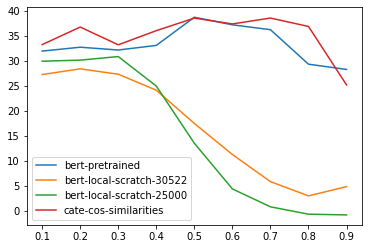

In [4]:
plt.figure()
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], pmis[0]['ensemble_score_bert-pretrained'], label='bert-pretrained')
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         pmis[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         pmis[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         pmis[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities')
plt.legend()
plt.show()


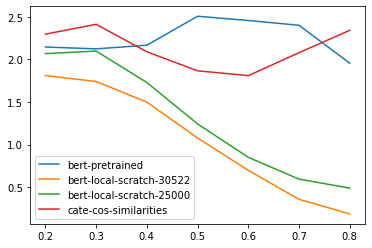

In [14]:
plt.figure()
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         npmis[0]['ensemble_score_bert-pretrained'],
         label='bert-pretrained')
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         npmis[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         npmis[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         npmis[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities')
plt.legend()
plt.show()


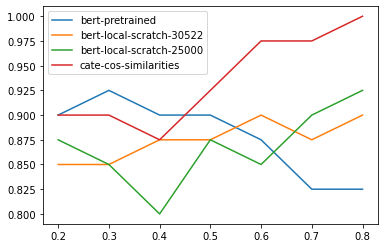

In [12]:
plt.figure()
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         sem_dists[0]['ensemble_score_bert-pretrained'],
         label='bert-pretrained')
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         sem_dists[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         sem_dists[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         sem_dists[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities')
plt.legend()
plt.show()


In [ ]:
plt.figure()
plt.plot([0.3, 0.4, 0.5, 0.6, 0.7],
         dists[0]['ensemble_score_bert-pretrained'],
         label='bert-pretrained')
plt.plot([0.3, 0.4, 0.5, 0.6, 0.7],
         dists[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
plt.plot([0.3, 0.4, 0.5, 0.6, 0.7],
         dists[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
plt.plot([0.3, 0.4, 0.5, 0.6, 0.7],
         dists[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities')
plt.legend()
plt.show()

In [56]:
l = 0.5
g = 0.8
import numpy as np
def ensemble_ranking(score_g, score_l, rho, weight_global, weight_local):
    exponent = 1 / rho
    base = weight_global * np.power(
        1 / score_g, rho) + weight_local * np.power(1 / score_l, rho)
    return 1 / np.power(base, exponent)
for i in range(1, 10):
    print(f"w_g={1-i/10}, w_l={i/10}")
    print(ensemble_ranking(g, l,0.1, 1-i/10, i/10))

w_g=0.9, w_l=0.1
0.7625017139527153
w_g=0.8, w_l=0.2
0.7269277933085015
w_g=0.7, w_l=0.3
0.6931710062212096
w_g=0.6, w_l=0.4
0.6611305640675668
w_g=0.5, w_l=0.5
0.6307117064380795
w_g=0.4, w_l=0.6
0.6018253146364971
w_g=0.30000000000000004, w_l=0.7
0.5743875516084382
w_g=0.19999999999999996, w_l=0.8
0.5483195263802467
w_g=0.09999999999999998, w_l=0.9
0.5235469812365003
